In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from glob import glob

In [3]:
df = pd.DataFrame()
for f in glob("datasets/*.csv"):
    df = pd.concat([df, pd.read_csv(f)], ignore_index=True)
df["pseudchartTime"] = pd.to_datetime(df["pseudchartTime"], format="%d/%m/%Y %H:%M")

In [4]:
columns = [
    "pO2 kPa (ABL)",
    "pCO2 kPA (ABL)",
    "Na+ mmol/L (ABL)",
    "Ca++ mmol/L (ABL)",
    "Cl- mmol/L (ABL)",
    "Lactate mmol/L (ABL)",
    "Albumin",
    "Urea",
    "Phosphate",
    "pH (ABL)",
]
sample = df.query("longLabel in @columns")
sample = sample.pivot_table(
    index=["alias", "pseudchartTime"], columns="longLabel", values="valueNumber"
).reset_index()
sample["alias"] = (
    sample["alias"].str.split("-").str[1].apply(lambda x: f"G-{int(x):02}")
)

In [5]:
data = sample.copy()
data = data.rename(
    {
        "pCO2 kPA (ABL)": "pco2",
        "pO2 kPa (ABL)": "po2",
        "Na+ mmol/L (ABL)": "na",
        "Cl- mmol/L (ABL)": "cl",
        "Ca++ mmol/L (ABL)": "ca",
        "Albumin": "albumin",
        "Lactate mmol/L (ABL)": "lactate",
        "Urea": "urea",
        "Phosphate": "phosphate",
        "pH (ABL)": "ph",
    },
    axis=1,
)

data = data.sort_values(["alias", "pseudchartTime"])
data["sid"] = data["na"] + data["ca"] - data["cl"]
data_gap = data.copy()

# ffill albumin
for col in ["albumin", "phosphate", "urea"]:
    data[col] = data.groupby("alias")[col].ffill()
    data[col] = data.groupby("alias")[col].bfill()

# data = data.dropna()

# Interpolation

In [6]:
from interpolations import *

agg_patient = (
    data_gap.groupby(["alias", pd.Grouper(key="pseudchartTime", freq="1h")])
    .mean(numeric_only=True)
    .reset_index()
    .copy()
)
agg_patient["unix_timestamp"] = agg_patient["pseudchartTime"].astype(int) / 1e9 / 3600


def get_patient(agg_patient, alias, admission=None):
    patient = agg_patient.query("alias == @alias")
    if admission is not None:
        patient = patient.query("admission == @admission")
    patient = (
        patient.set_index("pseudchartTime")
        .resample("1h")
        .mean(numeric_only=True)
        .reset_index()
        .copy()
    )
    patient["unix_timestamp"] = patient["pseudchartTime"].astype(int) / 1e9 / 3600
    return patient

In [7]:
from sklearn.cluster import DBSCAN

mdl = DBSCAN(eps=24 * 7)
agg_patient["admission"] = mdl.fit_predict(agg_patient[["unix_timestamp"]])
agg_patient["window"] = agg_patient.apply(
    lambda x: f"{x.alias} + {x.admission}", axis=1
)

In [8]:
agg_patient.groupby(["alias", "admission"]).size()

alias  admission
G-01    0            55
G-02    1            41
G-03   -1             7
        2            43
G-04    3            17
G-05    3            67
G-06    4            56
G-07    5            54
G-08    6             9
G-09    7            23
G-10    8           124
        9            84
G-11    10           13
G-12   -1             4
        11           49
        12           30
        13           23
G-13    14           74
G-14    15           69
dtype: int64

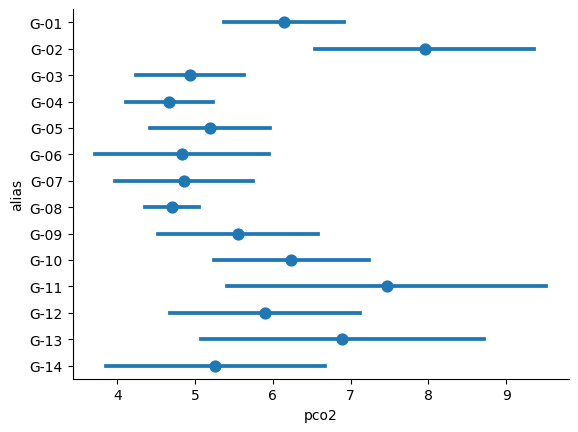

In [9]:
sns.pointplot(
    x="pco2",
    y="alias",
    errorbar="sd",
    linestyle="none",
    data=agg_patient,
)
sns.despine()

In [10]:
from enum import Enum
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import dgpsi as dgp

/Users/ali.septiandri/miniforge3/envs/phd/lib/python3.9/site-packages/numba/cpython/hashing.py:482: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


# Linked GP

In [11]:
import dgpsi as dgp


class LinkedGP:
    def __init__(self, features: list[str]):
        self.is_fitted = False
        self.features = features
        self._input_models = []
        self._output_model = None

    @classmethod
    def train_gp_complete_case(cls, X, H, **kwargs):
        x = np.hstack([X, H])
        mask_not_nan = ~np.isnan(x).reshape(x.shape[0], -1).sum(axis=1).astype(bool)
        model = dgp.gp(
            X[mask_not_nan],
            H[mask_not_nan].reshape(-1, 1),
            dgp.kernel(**kwargs),
        )

        model.train()
        return model

    def link_models(self, input_models, output_model):
        input_models_container = []
        for model in input_models:
            input_models_container.append(
                dgp.container(model.export(), local_input_idx=np.array([0]))
            )

        output_container = [
            dgp.container(
                output_model.export(), local_input_idx=np.arange(len(self.features))
            )
        ]

        struc = [input_models_container, output_container]
        lm = dgp.lgp(struc)
        return lm

    def fit(self, X, H, Y):
        kernel_args = dict(
            length=np.array([0.5]),
            name="sexp",
            scale_est=False,
        )

        for i, feature in enumerate(self.features):
            self._input_models.append(
                self.train_gp_complete_case(
                    X=X,
                    H=H[:, i].reshape(-1, 1),
                    nugget_est=False,
                    nugget=1e-6,
                    **kernel_args
                )
            )

        self._output_model = self.train_gp_complete_case(
            X=H, H=Y, nugget_est=True, nugget=1e-3, **kernel_args
        )

        self.lm = self.link_models(
            input_models=self._input_models, output_model=self._output_model
        )
        self.is_fitted = True

    def predict(self, X, full_layer=False):
        """Returns mean and var by default"""
        if self.is_fitted:
            return self.lm.predict(X, full_layer=full_layer)
        else:
            raise Exception("Model is not fitted.")


class DGP:
    def __init__(self, features, n_iter=300):
        self.features = features
        self.n_iter = n_iter

    def fit(self, X, H, Y):
        layer1 = [
            dgp.kernel(
                length=np.array([0.1]),
                name="sexp",
                scale_est=False,
                nugget_est=False,
                nugget=1e-6,
            )
            for _ in range(len(self.features))
        ]
        layer2 = [
            dgp.kernel(
                length=np.array([0.1]),
                name="sexp",
                scale_est=False,
                nugget_est=False,
                nugget=1e-3,
                connect=np.arange(1),
            )
        ]
        all_layers = dgp.combine(layer1, layer2)

        # Using observed latent variables
        self.m = dgp.dgp(X, [H, Y], all_layers)
        self.m.train(N=self.n_iter, disable=True)

        return self

    def predict(self, X, full_layer=False):
        final_layer_obj = self.m.estimate()
        emu = dgp.emulator(final_layer_obj)
        mu, var = emu.predict(X, method="mean_var", full_layer=full_layer)
        return mu, var


class GP:
    def __init__(self):
        pass

    def fit(self, X, Y):
        self.model = dgp.gp(
            X,
            Y,
            dgp.kernel(
                length=np.array([1.0]),
                name="sexp",
                scale_est=False,
                nugget_est=False,
                nugget=1e-3,
            ),
        )
        self.model.train()

    def predict(self, X):
        mu, var = self.model.predict(X)
        return mu, var

## Modelling time $\rightarrow$ (pCO2, SID, lactate) $\rightarrow$ pH

In [61]:
window = "G-07 + 5"
features = [
    "pco2",
    "sid",
    "lactate",
]

alias, admission = window.split(" + ")
admission = int(admission)

patient_per_hour = get_patient(agg_patient, alias, admission)
patient_df = patient_per_hour.dropna(subset="ph").copy()
# patient_df['all_na'] = np.nan

y_scaler = StandardScaler()
Y = y_scaler.fit_transform(patient_df[["ph"]].values)

X = patient_df[["unix_timestamp"]].values
X = (X - X.min()) / (X.max() - X.min())

scaler = StandardScaler()
H = scaler.fit_transform(patient_df[features].values)
imin, imax = 20, 25
# imin, imax = 25, 30
# imin, imax = 30, 40
H[imin:imax, :] = np.nan

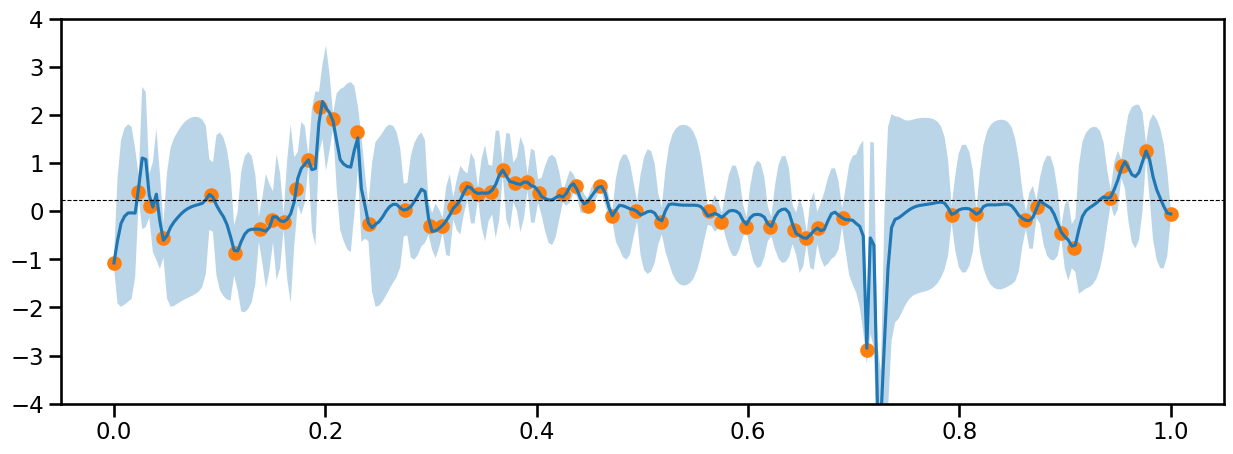

In [62]:
np.random.seed(42)

model = DGP(features=features, n_iter=1000)
model.fit(X, H, Y)

z = np.linspace(0, 1, 300)[:, None].reshape(-1, 1)
ml, vl = model.predict(z, full_layer=True)
lbl = (ml[1] - 2 * np.sqrt(vl[1])).flatten()
ubl = (ml[1] + 2 * np.sqrt(vl[1])).flatten()

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(z.flatten(), ml[1].flatten())
plt.fill_between(z.flatten(), lbl, ubl, alpha=0.3)
plt.scatter(X, Y)
plt.axhline(y_scaler.transform([[7.4]]), linestyle="--", linewidth=0.8, c="k")
plt.ylim(-4, 4);

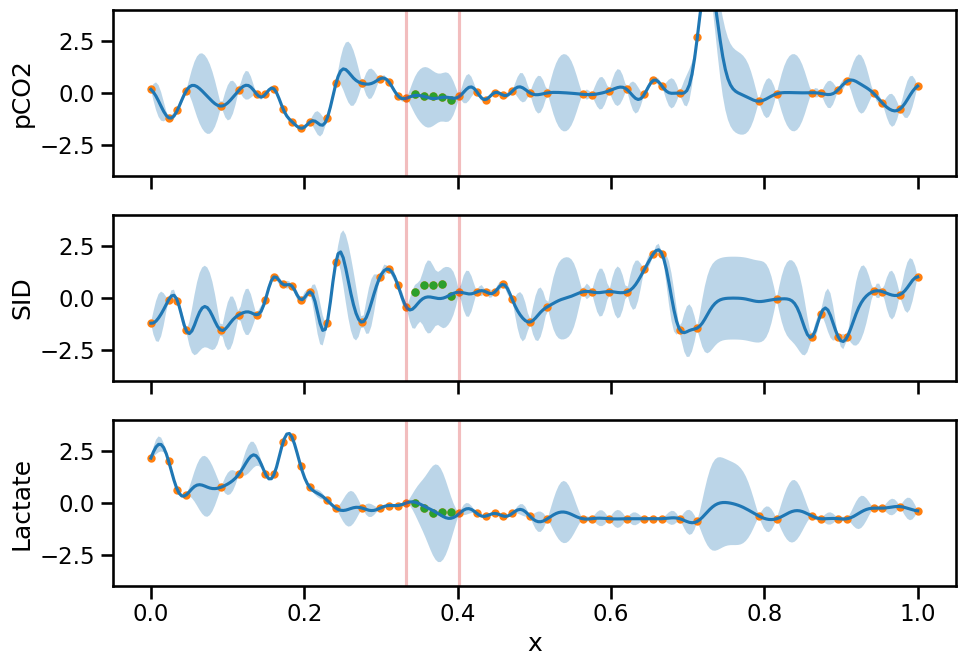

In [63]:
sns.set_context("talk")
fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(10, 7))

H = scaler.transform(patient_df[features].values)

for i, ax in enumerate(axes.flatten()):
    lbl = (ml[0][:, i] - 2 * np.sqrt(vl[0][:, i])).flatten()
    ubl = (ml[0][:, i] + 2 * np.sqrt(vl[0][:, i])).flatten()

    ax.plot(z.flatten(), ml[0][:, i].flatten())
    ax.fill_between(z.flatten(), lbl, ubl, alpha=0.3)
    ax.scatter(X, H[:, i], marker='.')
    ax.scatter(X[imin:imax], H[imin:imax, i], marker='.', color='C2')
    ax.set_ylim(-4, 4)
    ax.axvline(X[imin-1], color='C3', alpha=.3)
    ax.axvline(X[imax], color='C3', alpha=.3)
axes[0].set_ylabel("pCO2")
axes[1].set_ylabel("SID")
axes[2].set_ylabel("Lactate")
# axes[2].scatter(X[imin:imax], H[imin:imax, 2], marker='.', color='C2')
ax.set_xlabel("x")
plt.tight_layout()
plt.savefig("figures/dgp-features-masked-all-1-m.pdf", bbox_inches="tight")

/Users/ali.septiandri/miniforge3/envs/phd/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


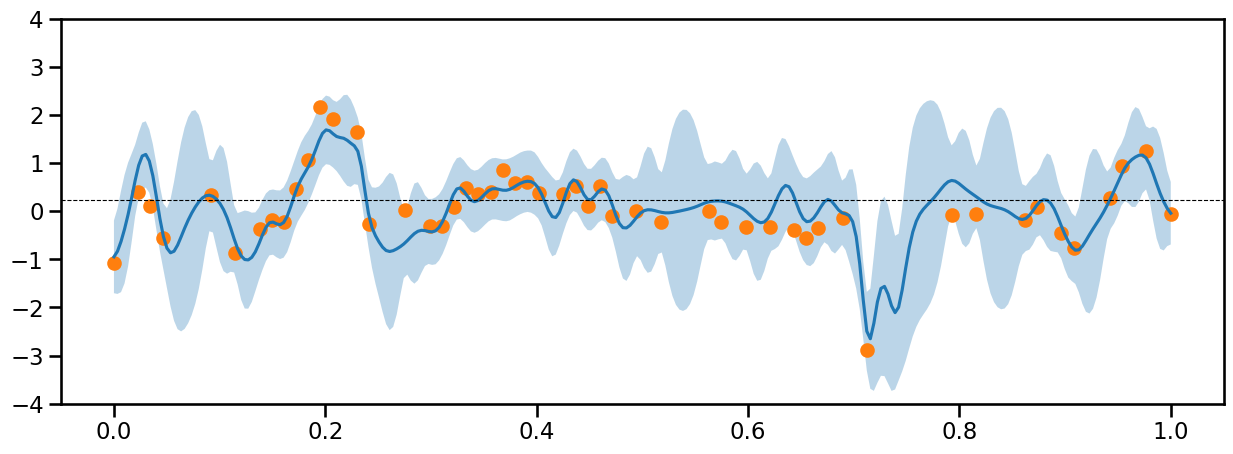

In [48]:
linked_gp = LinkedGP(features=features)
linked_gp.fit(X, H, Y)

z = np.linspace(0, 1, 300)[:, None].reshape(-1, 1)
ml, vl = linked_gp.predict(z)
lbl = (ml[0] - 2 * np.sqrt(vl[0])).flatten()
ubl = (ml[0] + 2 * np.sqrt(vl[0])).flatten()

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(z, ml[0])
plt.fill_between(z.flatten(), lbl, ubl, alpha=0.3)
plt.scatter(X, Y)
plt.axhline(y_scaler.transform([[7.4]]), linestyle="--", linewidth=0.8, c="k")
plt.ylim(-4, 4);

# Experiment

In [77]:
windows = agg_patient.dropna(subset="ph").groupby('window').size()
windows[windows.ge(windows.quantile(.25))]

window
G-01 + 0      53
G-02 + 1      39
G-03 + 2      36
G-05 + 3      59
G-06 + 4      51
G-07 + 5      53
G-09 + 7      20
G-10 + 8     115
G-10 + 9      78
G-12 + 11     40
G-12 + 12     28
G-12 + 13     19
G-13 + 14     65
G-14 + 15     64
dtype: int64

In [78]:
def ampute(df, label_columns, p_missing):
    X = df.copy()
    n_missing_samples = int(p_missing * X.shape[0])
    for label_column in label_columns:
        indices = np.random.choice(X.index, n_missing_samples, replace=False)
        X.loc[indices, label_column] = np.nan
    return X

In [79]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

np.random.seed(10)

features = ["pco2", "sid", "lactate"]
maes = []
windows = agg_patient.dropna(subset="ph").groupby("window").size()
windows = windows[windows.gt(windows.quantile(0.25))].index

for p_missing in tqdm(np.arange(0.1, 0.5, 0.1)):
    for window in windows:
        patient_df = pd.read_csv(
            f"experiments/features/{p_missing:.1f}_{window}_0_filled.csv"
        )

        for i in range(10):
            amputed_df = pd.read_csv(
                f"experiments/features/{p_missing:.1f}_{window}_{i}_masked.csv"
            )
            is_amputed = amputed_df[features].isna().values

            y_scaler = StandardScaler()
            Y = y_scaler.fit_transform(amputed_df[["ph"]].values)

            minmaxscaler = MinMaxScaler()
            X = minmaxscaler.fit_transform(amputed_df[["unix_timestamp"]].values)

            X_pred = minmaxscaler.transform(patient_df[["unix_timestamp"]].values)

            scaler = StandardScaler()
            H = scaler.fit_transform(amputed_df[features].values)
            x_true = scaler.transform(patient_df[features].values)[is_amputed]

            try:
                # Linked GP
                model = DGP(features, n_iter=100)
                model.fit(X, H, Y)
                mean, var = model.predict(X_pred, full_layer=True)
                imputed_dgp = mean[0]
                x_pred_dgp = imputed_dgp[is_amputed]
                assert x_true.shape == x_pred_dgp.shape

                # MICE
                # imputer = IterativeImputer()
                # imputed_mice = imputer.fit_transform(
                #     amputed_df[features + ["ph"]]
                # )
                # imputed_mice = scaler.transform(imputed_mice[:,:-1])
                # x_pred_mice = imputed_mice[is_amputed]
                # assert x_true.shape == x_pred_mice.shape

                # Forward Fill
                imputed_ffill = amputed_df[features].ffill().bfill()
                imputed_ffill = scaler.transform(imputed_ffill.values)
                x_pred_ffill = imputed_ffill[is_amputed]
                assert x_true.shape == x_pred_ffill.shape

                # Values may contain nan's before amputation
                is_observed = ~np.isnan(x_true)

                maes.append(
                    {
                        "window": window,
                        "iter": i,
                        "n": patient_df.shape[0],
                        "p_missing": p_missing,
                        "mae dgp": mean_absolute_error(
                            x_true[is_observed], x_pred_dgp[is_observed]
                        ),
                        # "mae mice": mean_absolute_error(
                        #     x_true[is_observed], x_pred_mice[is_observed]
                        # ),
                        "mae ffill": mean_absolute_error(
                            x_true[is_observed], x_pred_ffill[is_observed]
                        ),
                    }
                )
            except:
                pass

    # pd.DataFrame(maes).to_parquet(f"results-lgp-{p_missing:.1f}.parquet")

100%|██████████| 4/4 [5:32:59<00:00, 4994.91s/it]  


In [80]:
df_maes = pd.DataFrame(maes)
df_maes.to_parquet('results/20241113/features-dgp.parquet')